In [1]:
import argparse
import torch
import numpy as np
import torchvision
from backbones.ncsnpp_generator_adagn_feat import NCSNpp
from backbones.ncsnpp_generator_adagn_feat import NCSNpp_adaptive

In [3]:
def load_checkpoint(checkpoint_dir, netG, name_of_network, device='cuda:0'):
    checkpoint_file = checkpoint_dir.format(name_of_network)

    checkpoint = torch.load(checkpoint_file, map_location=device)
    ckpt = checkpoint

    for key in list(ckpt.keys()):
        ckpt[key[7:]] = ckpt.pop(key)
    netG.load_state_dict(ckpt, strict=False)
    netG.eval()


In [4]:
# %% Diffusion coefficients
def var_func_vp(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    var = 1. - torch.exp(2. * log_mean_coeff)
    return var


def var_func_geometric(t, beta_min, beta_max):
    return beta_min * ((beta_max / beta_min) ** t)


def extract(input, t, shape):
    out = torch.gather(input, 0, t)
    reshape = [shape[0]] + [1] * (len(shape) - 1)
    out = out.reshape(*reshape)

    return out


def get_time_schedule(args, device):
    n_timestep = args.num_timesteps
    eps_small = 1e-3
    t = np.arange(0, n_timestep + 1, dtype=np.float64)
    t = t / n_timestep
    t = torch.from_numpy(t) * (1. - eps_small) + eps_small
    return t.to(device)


def get_sigma_schedule(args, device):
    n_timestep = args.num_timesteps
    beta_min = args.beta_min
    beta_max = args.beta_max
    eps_small = 1e-3

    t = np.arange(0, n_timestep + 1, dtype=np.float64)
    t = t / n_timestep
    t = torch.from_numpy(t) * (1. - eps_small) + eps_small

    if args.use_geometric:
        var = var_func_geometric(t, beta_min, beta_max)
    else:
        var = var_func_vp(t, beta_min, beta_max)
    alpha_bars = 1.0 - var
    betas = 1 - alpha_bars[1:] / alpha_bars[:-1]

    first = torch.tensor(1e-8)
    betas = torch.cat((first[None], betas)).to(device)
    betas = betas.type(torch.float32)
    sigmas = betas ** 0.5
    a_s = torch.sqrt(1 - betas)
    return sigmas, a_s, betas


# %% posterior sampling
class Posterior_Coefficients():
    def __init__(self, args, device):
        _, _, self.betas = get_sigma_schedule(args, device=device)

        # we don't need the zeros
        self.betas = self.betas.type(torch.float32)[1:]

        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, 0)
        self.alphas_cumprod_prev = torch.cat(
            (torch.tensor([1.], dtype=torch.float32, device=device), self.alphas_cumprod[:-1]), 0
        )
        self.posterior_variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.rsqrt(self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod - 1)

        self.posterior_mean_coef1 = (self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1 - self.alphas_cumprod))
        self.posterior_mean_coef2 = (
                (1 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1 - self.alphas_cumprod))

        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))


def sample_posterior(coefficients, x_0, x_t, t):
    def q_posterior(x_0, x_t, t):
        mean = (
                extract(coefficients.posterior_mean_coef1, t, x_t.shape) * x_0
                + extract(coefficients.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        var = extract(coefficients.posterior_variance, t, x_t.shape)
        log_var_clipped = extract(coefficients.posterior_log_variance_clipped, t, x_t.shape)
        return mean, var, log_var_clipped

    def p_sample(x_0, x_t, t):
        mean, _, log_var = q_posterior(x_0, x_t, t)

        noise = torch.randn_like(x_t)

        nonzero_mask = (1 - (t == 0).type(torch.float32))

        return mean + nonzero_mask[:, None, None, None] * torch.exp(0.5 * log_var) * noise

    sample_x_pos = p_sample(x_0, x_t, t)

    return sample_x_pos


def sample_posterior_combine(coefficients, x_0_1, x_0_2, x_t, t):
    def q_posterior(x_0_1, x_0_2, x_t, t):
        mean1 = (
                extract(coefficients.posterior_mean_coef1, t, x_t.shape) * x_0_1
                + extract(coefficients.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        mean2 = (
                extract(coefficients.posterior_mean_coef1, t, x_t.shape) * x_0_2
                + extract(coefficients.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        mean = (mean1 + mean2) / 2

        var = extract(coefficients.posterior_variance, t, x_t.shape)
        log_var_clipped = extract(coefficients.posterior_log_variance_clipped, t, x_t.shape)
        return mean, var, log_var_clipped

    def p_sample(x_0_1, x_0_2, x_t, t):
        mean, _, log_var = q_posterior(x_0_1, x_0_2, x_t, t)

        noise = torch.randn_like(x_t)

        nonzero_mask = (1 - (t == 0).type(torch.float32))

        return mean + nonzero_mask[:, None, None, None] * torch.exp(0.5 * log_var) * noise

    sample_x_pos = p_sample(x_0_1, x_0_2, x_t, t)

    return sample_x_pos


def sample_from_model(coefficients, generator1, cond1, generator2, cond2, cond3, n_time, x_init, T, opt):
    x = x_init

    with torch.no_grad():
        for i in reversed(range(n_time)):
            t = torch.full((x.size(0),), i, dtype=torch.int64).to(x.device)

            t_time = t
            latent_z = torch.randn(x.size(0), opt.nz, device=x.device)  # .to(x.device)

            x_0_1 = generator1(x, cond1, cond2, cond3, t_time, latent_z)
            x_0_2 = generator2(x, cond1, cond2, cond3, t_time, latent_z, x_0_1[:, [0], :])

            x_new = sample_posterior_combine(coefficients, x_0_1[:, [0], :], x_0_2[:, [0], :], x, t)

            x = x_new.detach()

    return x


In [7]:
import argparse
device='cuda:0'
# Define all arguments as a Namespace for use in Jupyter Notebook
args = argparse.Namespace(
    # General setup
    seed=1024,
    compute_fid=False,
    epoch_id=1000,

    # Diffusion process parameters
    num_timesteps=4,
    beta_min=0.1,
    beta_max=20.0,
    centered=True,
    use_geometric=False,

    # Model architecture parameters
    num_channels=1,
    num_channels_dae=64,
    n_mlp=3,
    ch_mult=[1, 2, 4],
    num_res_blocks=2,
    attn_resolutions=(16,),
    dropout=0.0,
    resamp_with_conv=True,
    conditional=True,
    fir=True,
    fir_kernel=[1, 3, 3, 1],
    skip_rescale=True,
    resblock_type='biggan',
    progressive='none',
    progressive_input='residual',
    progressive_combine='sum',
    embedding_type='positional',
    fourier_scale=16.0,
    not_use_tanh=False,

    # Experiment setup
    exp='ixi_synth',
    input_path='./input',
    output_path='./output',
    dataset='cifar10',
    image_size=256,

    # Generator-specific parameters
    nz=100,
    z_emb_dim=256,
    t_emb_dim=256,
    batch_size=1,

    # Optimizer parameters
    lr_g=1.5e-4,
    beta1=0.5,
    beta2=0.9,

    # Hardware configuration
    gpu_chose=0,
)


# Example of modifying an argument interactively
args.num_timesteps = 1000
args.exp = 'experiment_name'

gen_diffusive_1 = NCSNpp(args).to(device)
gen_diffusive_2 = NCSNpp_adaptive(args).to(device)

# Load checkpoints
load_checkpoint(r'models\gen_diffusive_1.pth', gen_diffusive_1, 'gen_diffusive_1', device=device)
load_checkpoint(r'models\gen_diffusive_2.pth', gen_diffusive_2, 'gen_diffusive_2', device=device)


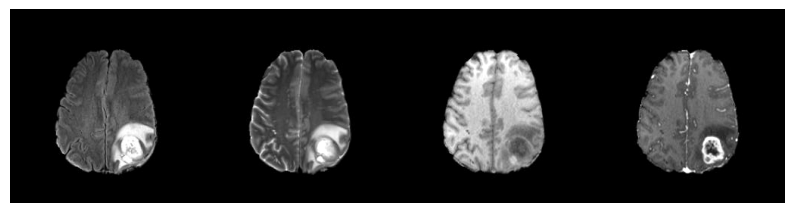

In [47]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms
import matplotlib.pyplot as plt

# Normalize the image using min-max scaling
def normalize(image):
    """Basic min max scaler."""
    min_ = np.min(image)
    max_ = np.max(image)
    scale = max_ - min_
    image = (image - min_) / scale
    return image

# Pre-process using IRM min-max scaling
def irm_min_max_preprocess(image, low_perc=1, high_perc=99):
    """Main pre-processing function for removing outliers and scaling."""
    non_zeros = image > 0
    low, high = np.percentile(image[non_zeros], [low_perc, high_perc])
    image = np.clip(image, low, high)
    image = normalize(image)
    return image

# Load and preprocess a single image
def load_image(image_path, size=(256, 256)):
    """
    Loads an image from the specified path, preprocesses it, and returns it as a tensor with shape (1, 1, 256, 256).
    """
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size),
        torchvision.transforms.ToTensor()  # This will convert the image to a tensor of shape (1, 256, 256)
    ])
    
    img = Image.open(image_path).convert("L")  # Convert to grayscale ('L' mode for single channel)
    img_np = np.array(img)  # Convert to numpy array for min-max scaling

    
    # Apply IRM min-max pre-processing
    img_np = irm_min_max_preprocess(img_np)
    
    # Normalize to [-1, 1] by applying (data - 0.5) / 0.5
    img_np = (img_np - 0.5) / 0.5
    
    # Convert back to tensor and add batch and channel dimensions
    img_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 256, 256)
    
    return img_tensor

# Specify paths to the images
x1_path = r'\sample_data\flair.jpg'
x2_path =r'\sample_data\t2.jpg'
x3_path =r'\sample_data\t1.jpg'
real_data_path = r'\sample_data\t1ce.jpg'

# Load images
x1 = load_image(x1_path).cuda()
x2 = load_image(x2_path).cuda()
x3 = load_image(x3_path).cuda()
real_data = load_image(real_data_path).cuda()

x1=torch.rot90(x1, k=-1, dims=(2, 3))
x2=torch.rot90(x2, k=-1, dims=(2, 3))
x3=torch.rot90(x3, k=-1, dims=(2, 3))
real_data=torch.rot90(real_data, k=-1, dims=(2, 3))

sample_inputs = torch.cat((x1, x2, x3, real_data), axis=-1)  # Concatenate along the width

# Squeeze the tensor to remove the batch and channel dimensions for visualization
sample_inputs = sample_inputs.squeeze(0).squeeze(0)  # Shape: (256, 256, 5)

# Plot the concatenated image
plt.figure(figsize=(10, 10))
plt.imshow(sample_inputs.cpu().numpy(), cmap='gray')  # Display in grayscale
plt.axis('off')  # Hide axes
plt.show()


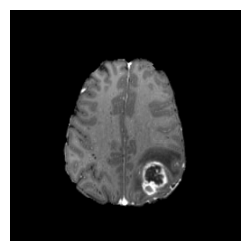

In [45]:
T = get_time_schedule(args, device)
pos_coeff = Posterior_Coefficients(args, device)

# Initialize noisy input
x1_t = torch.randn_like(real_data).cuda()

# Generate synthetic samples
fake_sample = sample_from_model(pos_coeff, gen_diffusive_1, x1, gen_diffusive_2, x2, x3,
                                 args.num_timesteps, x1_t, T, args)

# Normalize and save
to_range_0_1 = lambda x: (x + 1.) / 2.
fake_sample = to_range_0_1(fake_sample)

fake_sample = fake_sample*255.0
fake_sample = fake_sample.squeeze(0).squeeze(0)  # Shape: (256, 256, 5)


# Plot the concatenated image
plt.figure(figsize=(3, 3))
plt.imshow(fake_sample.cpu().numpy(), cmap='gray')  # Display in grayscale




plt.axis('off')  # Hide axes
plt.show()